In [ ]:
#@title
!git clone https://github.com/thsant/wgisd.git
HEIGHT, WIDTH = 1365, 2048
MASKTHRESH = 0.5
from google.colab import drive
drive.mount('/googledrive')
MODELPATH = '/googledrive/MyDrive/uczelnia/computer_vision/instance_segmentation_grapes/models/'
from random import shuffle
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.ssd import det_utils
from torchvision.ops import nms
import torchvision
import logging
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch
import warnings
import random
import colorsys
import matplotlib.pyplot as plt
from matplotlib import patches
from matplotlib.patches import Polygon
from skimage.color import label2rgb
import torch.nn.functional as F
from torchvision.ops import roi_align
from torchvision.models.detection.roi_heads import project_masks_on_boxes
from time import time
from pathlib import Path
import json

def random_colors(n_colors, bright=True):
    """
    Generate random colors.
    To get visually distinct colors, generate them in HSV space then
    convert to RGB.
    """
    brightness = 1.0 if bright else 0.7
    hsv = [(i / n_colors, 1, brightness) for i in range(n_colors)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors


def plot_item(img, boxes, mask, savename = None, maskthresh = MASKTHRESH):
    """
    Parameters:
        img : src image of shape (3, image_height, image_width) e.g. (3, 1365, 2048)
        boxes : boxes found objects (n_boxes, 4)
        mask : mask of found objects (n_boxes, image_height, image_width)
    Examples:
        sample parameters shape: ((3, 1365, 2048), (11, 4), (11, 1365, 2048))
    """
    if type(img) == torch.Tensor:
        img = img.detach().numpy()
    if type(boxes) == torch.Tensor:
        boxes = boxes.detach().numpy()
    if type(mask) == torch.Tensor:
        mask = mask.detach().numpy()
    if mask.shape[1] == 1:
        mask = mask.squeeze(1)
    if mask.dtype != np.uint8:
        mask = mask > maskthresh
        mask = mask.astype(np.uint8)
    fig, (ax0, ax1) = plt.subplots(figsize=(20,10), ncols=2, dpi = 200)

    # Number of instances
    n_boxes = boxes.shape[0]

    # Generate random colors
    colors = random_colors(n_boxes)

    for i, (x0, y0, x1, y1) in enumerate(boxes):
        color = np.array(colors[i])
        box_width = x1 - x0
        box_height = y1 - y0
        p = patches.Rectangle((x0, y0), box_width, box_height, linewidth=2,
                              alpha=0.7, linestyle="dashed",
                              edgecolor=color, facecolor='none')
        ax0.add_patch(p)
        ax0.text(x0 + 5, y0 + 25, '%.2d' % i, color=color, weight='bold', size=8)

        p = patches.Rectangle((x0, y0), box_width, box_height, linewidth=2,
                              alpha=0.7, linestyle="dashed",
                              edgecolor=color, facecolor='none')
        ax1.add_patch(p)
        ax1.text(x0 + 5, y0 + 25, '%.2d' % i, color=color, weight='bold', size=8)
        
        ax0.imshow(np.moveaxis(img, 0, -1))

    mask = np.moveaxis(mask, 0, -1)
    labels = np.zeros(mask.shape[0:2])
    for i in range(n_boxes):
        labels[mask[:,:,i] == 1] = i + 1
    mask_rgb = label2rgb(labels, colors=colors, bg_label=0)
    ax1.imshow(mask_rgb)
    if savename is not None:
        plt.savefig(savename)

class WGISDMaskedDataset(Dataset):
    def __init__(self, root, transforms=None, source='train'):
        self.root = root
        self.transforms = transforms
        
        if source not in ('train', 'test', 'valid'):
            print('source should be by "train" or "test"')
            return None

        srcpref = source
        if source == 'valid':
            srcpref = 'test'
        source_path = os.path.join(root, f'{srcpref}_masked.txt')
        with open(source_path, 'r') as fp:
          lines = fp.readlines()
          ids = [l.rstrip() for l in lines]# removes /n at the end of each line

        self.imgs = [os.path.join(root, 'data', f'{id}.jpg') for id in ids]
        self.masks = [os.path.join(root, 'data', f'{id}.npz') for id in ids]
        self.boxes = [os.path.join(root, 'data', f'{id}.txt') for id in ids]

        #performing additional dataset split test -> test, valid
        if source == 'test':
            self.imgs = self.imgs[len(self.imgs) // 2 : ]
            self.masks = self.masks[len(self.masks) // 2 : ]
            self.boxes = self.boxes[len(self.boxes) // 2 : ]
        elif source == 'valid':
            self.imgs = self.imgs[ : len(self.imgs) // 2 ]
            self.masks = self.masks[ : len(self.masks) // 2 ]
            self.boxes = self.boxes[ : len(self.boxes) // 2 ]

    def __getitem__(self, idx):
        img_path = self.imgs[idx]
        mask_path = self.masks[idx]
        box_path = self.boxes[idx]

        img = Image.open(img_path).convert("RGB")
        
        if self.transforms is None:
            pass
        else:
            img = np.array(img)
            img = self.transforms(torch.as_tensor(img, dtype=torch.uint8))

        img = np.array(img)
        # Normalize
        img = (img - img.min()) / np.max([img.max() - img.min(), 1])
        img = np.moveaxis(img, -1, 0)
        img = torch.as_tensor(img, dtype=torch.float32)  


        wgisd_masks = np.load(mask_path)['arr_0'].astype(np.uint8)
        masks = np.moveaxis(wgisd_masks, -1, 0) 

        num_objs = masks.shape[0]
        all_text = np.loadtxt(box_path, delimiter = " ", dtype = np.float32)
        wgisd_boxes = all_text[:,1:]
        assert(wgisd_boxes.shape[0] == num_objs)

        labels = np.ones(num_objs, dtype=np.int64)

        # According to WGISD:
        #
        # These text files follows the "YOLO format"
        # 
        # CLASS CX CY W H
        # 
        # class is an integer defining the object class – the dataset presents 
        # only the grape class that is numbered 0, so every line starts with 
        # this "class zero" indicator. The center of the bounding box is the 
        # point (c_x, c_y), represented as float values because this format 
        # normalizes the coordinates by the image dimensions. To get the 
        # absolute position, use (2048 c_x, 1365 c_y). The bounding box 
        # dimensions are given by W and H, also normalized by the image size.
        #
        # Torchvision's Mask R-CNN expects absolute coordinates.
        _, height, width = img.shape

        boxes = []
        for box in wgisd_boxes:
            x1 = box[0] - box[2]/2
            x2 = box[0] + box[2]/2
            y1 = box[1] - box[3]/2
            y2 = box[1] + box[3]/2
            boxes.append([x1 * width, y1 * height, x2 * width, y2 * height])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)
        image_id = torch.tensor([idx])

        target = {
            "boxes": boxes,
            "labels": labels,
            "masks": masks,
            "image_id": image_id
        }

        return img, target

    def __len__(self):
        return len(self.imgs)

def filter_results(results : dict, confidence_thresh = 0.8):
    res = results.copy()
    scores = results['scores']
    res['boxes'] = results['boxes'][scores > confidence_thresh]
    res['labels'] = results['labels'][scores >confidence_thresh]
    res['masks'] = results['masks'][scores>confidence_thresh]
    res['scores'] = results['scores'][scores > confidence_thresh]
    return res

def nmscombined(orig_predicted, iou_thresh = 0.3):
    '''
    performs non max suppression on the results
    '''
    keep = nms(orig_predicted['boxes'], orig_predicted['scores'], iou_thresh)
    final_pred = orig_predicted
    final_pred['boxes'] = final_pred['boxes'][keep]
    final_pred['masks'] = final_pred['masks'][keep]
    final_pred['scores'] = final_pred['scores'][keep]
    final_pred['labels'] = final_pred['labels'][keep]
    return final_pred

def calcTP(GTmasks, predmasks, predscores, IoU_thresh = 0.5, maskthresh = MASKTHRESH):
    """
    Parameters
    ----------
    GTmasks : Ground Truth masks
    predmasks : Predicted Masks from the model
    
    Returns
    ------------
    TruePositives
    """
    predmasks = predmasks > maskthresh
    metric = 0
    GTmasksEvaluated = [False for i in range(GTmasks.shape[0])]
    TP = 0
    for predmask in predmasks[predscores.argsort(descending = True)]:
        andresult=torch.logical_and(GTmasks, predmask )
        imgid = torch.argmax(andresult.sum([-1, -2]))
        if GTmasksEvaluated[imgid]:
            continue
        gtmask = GTmasks[imgid]
        intersection = andresult[imgid]
        union = torch.logical_or(gtmask, predmask)
        iou = intersection.sum() / union.sum()
        if iou >= IoU_thresh:
            GTmasksEvaluated[imgid] = True
            TP += 1
    return TP

def precision_frompreds(GTmasks, predmasks, predscores, IoU_thresh = 0.5, maskthresh = MASKTHRESH):
    TP = calcTP(GTmasks, predmasks, predscores, IoU_thresh, maskthresh)
    return TP / predmasks.shape[0]

def recall_frompreds(GTmasks, predmasks, predscores, IoU_thresh = 0.5,maskthresh = MASKTHRESH):
    TP = calcTP(GTmasks, predmasks, predscores, IoU_thresh, maskthresh)
    return TP / GTmasks.shape[0]

def fscore(precision, recall):
    return 2 * precision * recall / (precision + recall)

def print_datsetslens():
    train=WGISDMaskedDataset('./wgisd/', source='train')
    test=WGISDMaskedDataset('./wgisd/', source='test')
    valid = WGISDMaskedDataset('./wgisd/', source='valid')
    print('trainlen:', len(train))
    print('testlen:', len(test))
    print('validlen:', len(valid))
    den = len(train) + len(valid) + len(test)
    print(f'split proportion: {len(train) / den} : {len(test) / den} : {len(valid) / den}')

class DiceLoss(torch.nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice

class IoULoss(torch.nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(IoULoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #intersection is equivalent to True Positive count
        #union is the mutually inclusive area of all labels & predictions 
        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection 
        
        IoU = (intersection + smooth)/(union + smooth)
                
        return 1 - IoU


class LossIntoMaskRCNN(object):
    def __init__(self, lossfunction = 'bincrossentr_wl'):
        if lossfunction == 'bincrossentr_wl':
            self.loss = F.binary_cross_entropy_with_logits
        elif lossfunction == 'mse':
            self.loss = F.mse_loss
        elif lossfunction =='dice':
            self.loss = DiceLoss()
        elif lossfunction == 'iou':
            self.loss = IoULoss()
    def lossintomaskrcnn(self, mask_logits, proposals, gt_masks, gt_labels, mask_matched_idxs, loss = 'bincrossentr_wl'): 
        # type: (Tensor, List[Tensor], List[Tensor], List[Tensor], List[Tensor]) 
        """ 
        Arguments: 
            proposals (list[BoxList]) 
            mask_logits (Tensor) 
            targets (list[BoxList]) 

        Return: 
            mask_loss (Tensor): scalar tensor containing the loss 
        """ 

        discretization_size = mask_logits.shape[-1] 
        labels = [l[idxs] for l, idxs in zip(gt_labels, mask_matched_idxs)] 
        mask_targets = [ 
            project_masks_on_boxes(m, p, i, discretization_size) 
            for m, p, i in zip(gt_masks, proposals, mask_matched_idxs) 
        ] 

        labels = torch.cat(labels, dim=0) 
        mask_targets = torch.cat(mask_targets, dim=0) 

        # torch.mean (in binary_cross_entropy_with_logits) doesn't 
        # accept empty tensors, so handle it separately 
        if mask_targets.numel() == 0: 
            return mask_logits.sum() * 0 

        mask_loss = self.loss( 
            mask_logits[torch.arange(labels.shape[0], device=labels.device), labels], mask_targets 
        ) 
        return mask_loss

def availablelosses():
    return ['bincrossentr_wl', 'dice', 'iou', 'mse']
def availablelosses_tofunctions():
    return {'bincrossentr_wl':F.binary_cross_entropy_with_logits, 'dice':DiceLoss(), 'iou':IoULoss(),'mse':F.mse_loss}

def setloss(loss = 'bincrossentr_wl'):
    lossIMRCNN = LossIntoMaskRCNN(loss)
    torchvision.models.detection.roi_heads.maskrcnn_loss = lossIMRCNN.lossintomaskrcnn 

def eager_outputs_foo(losses, detections):
    return losses, detections

def get_maskrcnn(pretrained = True):
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=pretrained)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    #replace head predictor (boxes)
    NUM_CLASSES=2
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, NUM_CLASSES)
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    #replace mask predictor
    fg_iou_thresh = 0.5 #min IoU to be considered as positive
    bg_iou_thresh = 0.5 #max IoU to be considered as negative
    model.roi_heads.proposal_matcher.low_threshold = bg_iou_thresh
    model.roi_heads.proposal_matcher.high_threshold = fg_iou_thresh
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, NUM_CLASSES)
    # model.eager_outputs = eager_outputs_foo
    return model

Cloning into 'wgisd'...
remote: Enumerating objects: 4248, done.
remote: Counting objects: 100% (848/848), done.
remote: Compressing objects: 100% (839/839), done.
remote: Total 4248 (delta 19), reused 820 (delta 7), pack-reused 3400
Receiving objects: 100% (4248/4248), 1.39 GiB | 32.07 MiB/s, done.
Resolving deltas: 100% (342/342), done.
Checking out files: 100% (1849/1849), done.
Mounted at /googledrive


Print datasets lens:

In [ ]:
print_datsetslens()

trainlen: 110
testlen: 14
validlen: 14
split proportion: 0.7971014492753623 : 0.10144927536231885 : 0.10144927536231885


In [ ]:
def metrics(model, testloader, IoU_thresh = 0.5):
    prec = 0.0
    rec = 0.0
    counter = 0
    for batchid, (images, targets) in enumerate(testloader, 1):
        res = model(images)
        res = [filter_results(i, confidence_thresh = 0.8) for i in res]
        for resi, trgti in zip(res, targets):
            TP = calcTP(trgti['masks'], resi['masks'], resi['scores'], IoU_thresh = IoU_thresh)
            if resi['masks'].shape[0] == 0:
                counter += 1
                continue
            prec += TP / resi['masks'].shape[0]
            rec += TP/ trgti['masks'].shape[0]
            counter+=1
    prec /= counter
    rec /= counter
    return prec, rec, fscore(prec, rec)
modelnames = ['model5' + loss + '.pt' for loss in  availablelosses()]
modelnames

['model5bincrossentr_wl.pt', 'model5dice.pt', 'model5iou.pt', 'model5mse.pt']

modelname: model5bincrossentr_wl.pt


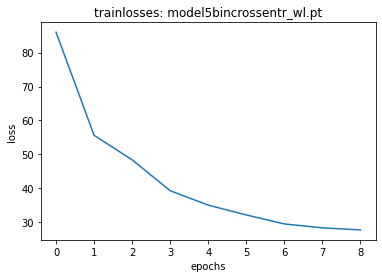

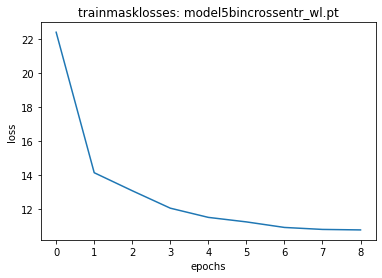

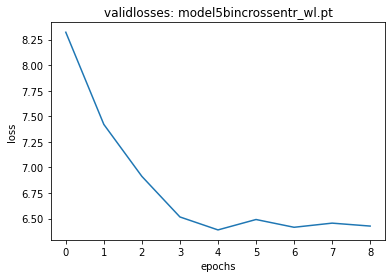

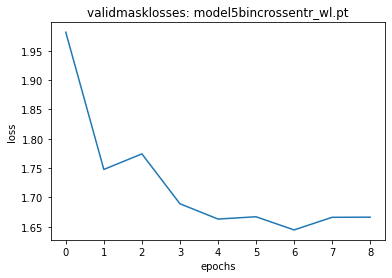

modelname: model5dice.pt


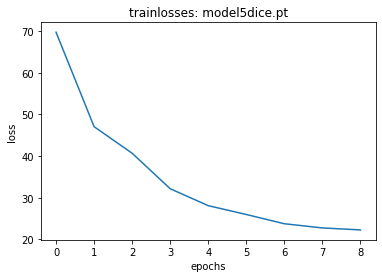

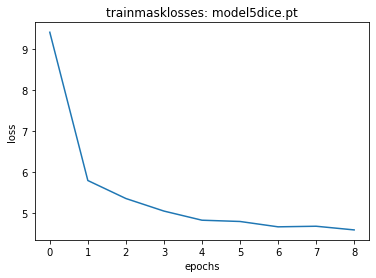

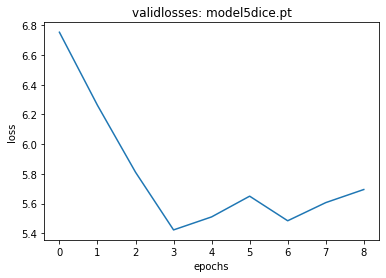

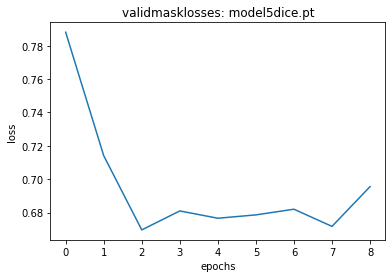

modelname: model5iou.pt


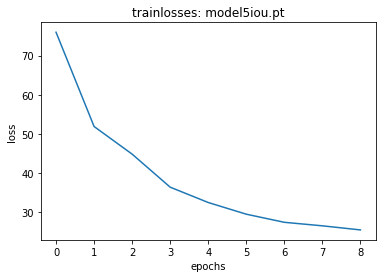

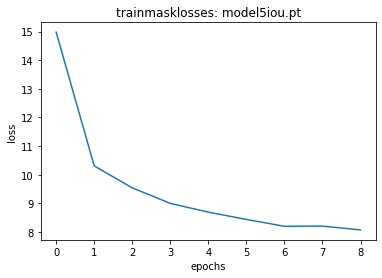

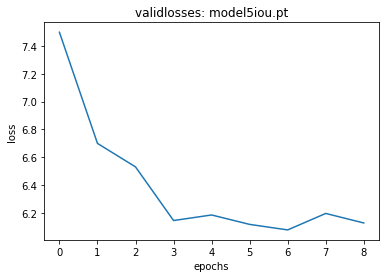

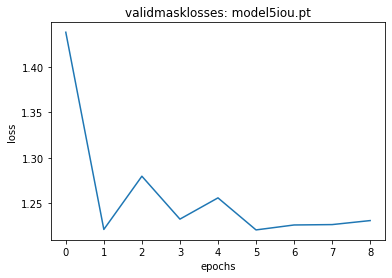

modelname: model5mse.pt


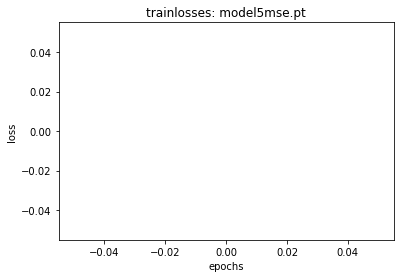

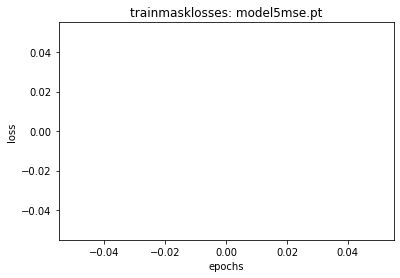

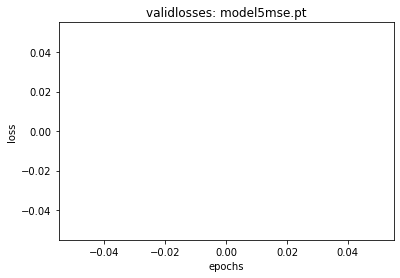

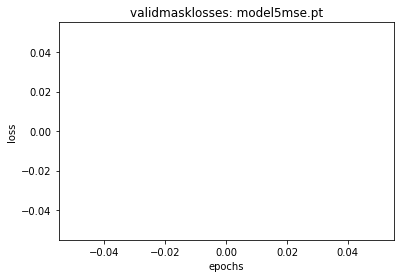

ZeroDivisionError: ignored

<Figure size 432x288 with 0 Axes>

In [ ]:
results = dict()
for modelname in modelnames:
    print("modelname:", modelname)
    with open( MODELPATH + '../' + 'differentlossfunctions/' + modelname + "_LOSSES.json" , "r" ) as f:
        (trainlosses, trainmasklosses), (validlosses, validmasklosses) = json.load(f)
    plt.plot(trainlosses)
    plt.title(f'trainlosses: {modelname}')
    plt.ylabel("loss")
    plt.xlabel("epochs")
    plt.show()
    plt.savefig(f'trainlosses|{modelname}.png')
    plt.plot(trainmasklosses)
    plt.title(f'trainmasklosses: {modelname}')
    plt.ylabel("loss")
    plt.xlabel("epochs")
    plt.show()
    plt.savefig(f'trainmasklosses|{modelname}.png')
    plt.plot(validlosses)
    plt.title(f'validlosses: {modelname}')
    plt.ylabel("loss")
    plt.xlabel("epochs")
    plt.show()
    plt.savefig(f'validlosses|{modelname}.png')
    plt.plot(validmasklosses)
    plt.title(f'validmasklosses: {modelname}')
    plt.ylabel("loss")
    plt.xlabel("epochs")
    plt.show()
    plt.savefig(f'validmasklosses|{modelname}.png')

    model = get_maskrcnn()
    if torch.cuda.is_available():
        model.load_state_dict(torch.load(os.path.join(MODELPATH + '../differentlossfunctions/', modelname)))
    else:
        model.load_state_dict(torch.load(os.path.join(MODELPATH + '../differentlossfunctions', modelname), map_location=torch.device('cpu')))
    model.eval()

    BATCH_SIZE = 2
    validdata = WGISDMaskedDataset('./wgisd', source = 'valid')
    validloader = DataLoader(validdata, BATCH_SIZE, shuffle=True, num_workers = 2, collate_fn=lambda s: tuple(zip(*s)))
    prec, rec, fsc = metrics(model, validloader)
    results[modelname] = dict(precision = prec, recall = rec, fscore = fsc)

In [ ]:
import pandas as pd
pd.DataFrame.from_dict(results, orient = 'index')

,precision,recall,fscore
model5bincrossentr_wl.pt,0.844651,0.866046,0.855214
model5dice.pt,0.843679,0.859823,0.851674
model5iou.pt,0.847819,0.848564,0.848191
